<a href="https://colab.research.google.com/github/burrows99/NLP_Project/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup & Data Loading

In [48]:
%pip install datasets transformers sklearn-crfsuite seqeval pandas

In [49]:
import numpy as np
import torch
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import pos_tag
from nltk.util import ngrams
from collections import defaultdict
from datasets import load_dataset
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite.utils import flatten
from sklearn_crfsuite import CRF, metrics
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from torch import nn
from seqeval.metrics import classification_report


# Load dataset and describe it

In [50]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")
splits = list(dataset.keys())

for split in splits:
    print(f"\n{split.upper()} Split:")
    print("="*50)
    df = dataset[split].to_pandas()
    print(df.head())
    print("="*50)


TRAIN Split:
                                              tokens  \
0  [MRR, ,, mortality, rate, ratio, ;, TBI, ,, tr...   
1  [HPC, ,, hippocampus, ;, mOFC, ,, medial, OFC,...   
2  [In, addition, to, the, effects, on, cell, gro...   
3  [Abbreviations, :, HC, ,, C, -, terminal, rece...   
4   [LL, :, lower, limit, ,, UL, :, upper, limit, .]   

                                            pos_tags  \
0  [NOUN, PUNCT, NOUN, NOUN, NOUN, PUNCT, PROPN, ...   
1  [PROPN, PUNCT, NOUN, PUNCT, NOUN, PUNCT, ADJ, ...   
2  [ADP, NOUN, ADP, DET, NOUN, ADP, NOUN, NOUN, C...   
3  [NOUN, PUNCT, PROPN, PUNCT, NOUN, PUNCT, ADJ, ...   
4  [PROPN, PUNCT, ADJ, NOUN, PUNCT, PROPN, PUNCT,...   

                                            ner_tags  
0  [B-AC, O, B-LF, I-LF, I-LF, O, B-AC, O, B-LF, ...  
1  [B-AC, O, B-LF, O, O, O, O, B-AC, O, B-AC, O, ...  
2  [O, O, O, O, O, O, O, O, O, O, O, O, B-AC, B-A...  
3  [O, O, B-AC, O, B-LF, I-LF, I-LF, I-LF, I-LF, ...  
4   [B-AC, O, B-LF, I-LF, O, B-AC, O,

# Split dataset

In [51]:
train_tokens = dataset['train']['tokens']
train_tags = dataset['train']['ner_tags']
train_pos = dataset['train']['pos_tags']

val_tokens = dataset['validation']['tokens']
val_tags = dataset['validation']['ner_tags']
val_pos = dataset['validation']['pos_tags']

test_tokens = dataset['test']['tokens']
test_tags = dataset['test']['ner_tags']
test_pos = dataset['test']['pos_tags']

# Print sample sizes
print(f"Training samples: {len(train_tokens)}")
print(f"Validation samples: {len(val_tokens)}")
print(f"Test samples: {len(test_tokens)}")

# Print first example from each split
print("\nFirst training example:")
print("Tokens:", train_tokens[0])
print("Tags:", train_tags[0])
print("POS:", train_pos[0])

print("\nFirst validation example:")
print("Tokens:", val_tokens[0])
print("Tags:", val_tags[0])
print("POS:", val_pos[0])

print("\nFirst test example:")
print("Tokens:", test_tokens[0])
print("Tags:", test_tags[0])
print("POS:", test_pos[0])

Training samples: 2000
Validation samples: 150
Test samples: 250

First training example:
Tokens: ['MRR', ',', 'mortality', 'rate', 'ratio', ';', 'TBI', ',', 'traumatic', 'brain', 'injury', '.']
Tags: ['B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O']
POS: ['NOUN', 'PUNCT', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT']

First validation example:
Tokens: ['Multi', '-', 'locus', 'sequence', 'typing', '(', 'MLST', ')', 'was', 'performed', 'by', 'PCR', '-', 'sequencing', 'of', 'a', 'set', 'of', 'pneumococcal', 'housekeeping', 'genes', ',', 'including', 'ardE', ',', 'gdh', ',', 'gki', ',', 'recP', ',', 'spi', ',', 'xpt', ',', 'and', 'ddl', '[', '17', ']', '.']
Tags: ['B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'O', 'B-AC', 'O', 'O', 'O', 'O', 'B-AC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
POS: ['ADJ', 'PUNCT', 'ADJ', 'NO

# Prepare common functions

In [52]:
def run_crf_pipeline(featurizer_func, dataset, crf_model, variation_name="Unnamed Variation"):
    print(f"\n=== Running CRF Pipeline: {variation_name} ===\n")

    # Prepare features
    X_train = [featurizer_func(s) for s in dataset['train']['tokens']]
    X_val = [featurizer_func(s) for s in dataset['validation']['tokens']]
    X_test = [featurizer_func(s) for s in dataset['test']['tokens']]

    # Prepare labels
    y_train = dataset['train']['ner_tags']
    y_val = dataset['validation']['ner_tags']
    y_test = dataset['test']['ner_tags']

    # Verify dataset sizes
    assert len(X_train) == len(y_train), "Train feature/label mismatch"
    assert len(X_val) == len(y_val), "Validation feature/label mismatch"
    assert len(X_test) == len(y_test), "Test feature/label mismatch"

    # Train model
    crf_model.fit(X_train, y_train)

    # Validate on validation set
    y_val_pred = crf_model.predict(X_val)
    print("=== Validation Set Report ===")
    print(classification_report(y_val, y_val_pred))

    # Final test on test set
    y_test_pred = crf_model.predict(X_test)
    print("\n=== Test Set Report ===")
    report_test = classification_report(y_test, y_test_pred, output_dict=True)
    print(report_test)
    # Plot F1-scores for each label
    plot_f1_scores(report_test, variation_name)

def plot_f1_scores(report_dict, variation_name):
    labels = []
    f1_scores = []

    for label, metrics in report_dict.items():
        labels.append(label)
        f1_scores.append(metrics["f1-score"])

    x = np.arange(len(labels))
    plt.figure(figsize=(10, 5))
    plt.bar(x, f1_scores, color='skyblue')
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.title(f'F1 Scores per Label - {variation_name}')
    plt.ylabel('F1 Score')
    plt.tight_layout()
    plt.show()

# Experiment 1: Varying Vectorization Methods (3 Systems)
**Systems:**
1. **System 1**: CRF with Basic Features (word, prefix, suffix)
2. **System 2**: CRF with Advanced Features (POS tags, n-grams)
3. **System 3**: BERT Embeddings + FFNN

# System 1 : CRF with Basic Features (word, prefix, suffix)


=== Running CRF Pipeline: System 1: Basic Featurizer v1 ===

=== Validation Set Report ===
              precision    recall  f1-score   support

          AC       0.81      0.47      0.60       508
          LF       0.50      0.38      0.43       306

   micro avg       0.67      0.44      0.53       814
   macro avg       0.66      0.43      0.52       814
weighted avg       0.69      0.44      0.54       814


=== Test Set Report ===
{'AC': {'precision': np.float64(0.8013698630136986), 'recall': np.float64(0.44040150564617314), 'f1-score': np.float64(0.5684210526315789), 'support': np.int64(797)}, 'LF': {'precision': np.float64(0.5508021390374331), 'recall': np.float64(0.42738589211618255), 'f1-score': np.float64(0.4813084112149532), 'support': np.int64(482)}, 'micro avg': {'precision': np.float64(0.6859605911330049), 'recall': np.float64(0.4354964816262705), 'f1-score': np.float64(0.5327594452415112), 'support': np.int64(1279)}, 'macro avg': {'precision': np.float64(0.6760860010

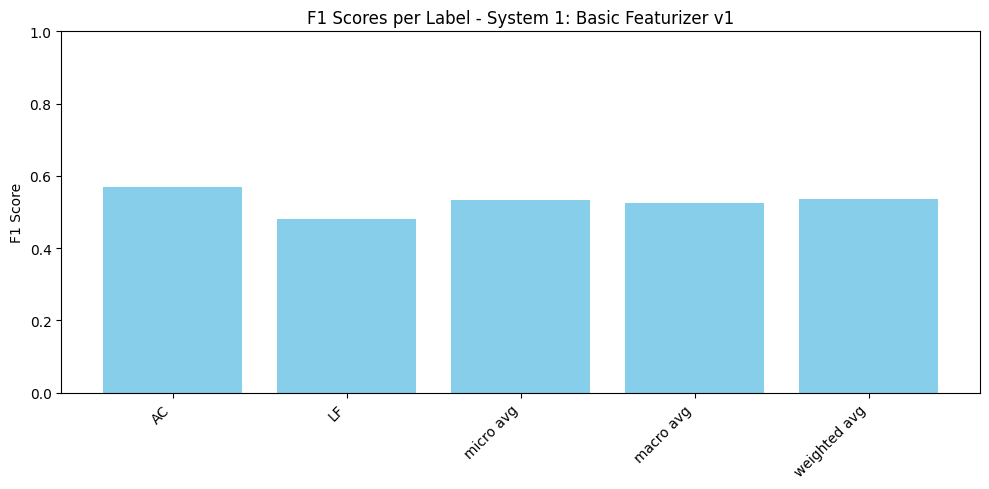


=== Running CRF Pipeline: System 1: Extended Featurizer v2 ===

=== Validation Set Report ===
              precision    recall  f1-score   support

          AC       0.76      0.78      0.77       508
          LF       0.51      0.41      0.45       306

   micro avg       0.68      0.64      0.66       814
   macro avg       0.64      0.59      0.61       814
weighted avg       0.67      0.64      0.65       814


=== Test Set Report ===
{'AC': {'precision': np.float64(0.7370283018867925), 'recall': np.float64(0.7841907151819323), 'f1-score': np.float64(0.7598784194528876), 'support': np.int64(797)}, 'LF': {'precision': np.float64(0.5602094240837696), 'recall': np.float64(0.44398340248962653), 'f1-score': np.float64(0.49537037037037035), 'support': np.int64(482)}, 'micro avg': {'precision': np.float64(0.6821138211382114), 'recall': np.float64(0.6559812353401094), 'f1-score': np.float64(0.6687923475488243), 'support': np.int64(1279)}, 'macro avg': {'precision': np.float64(0.6486188

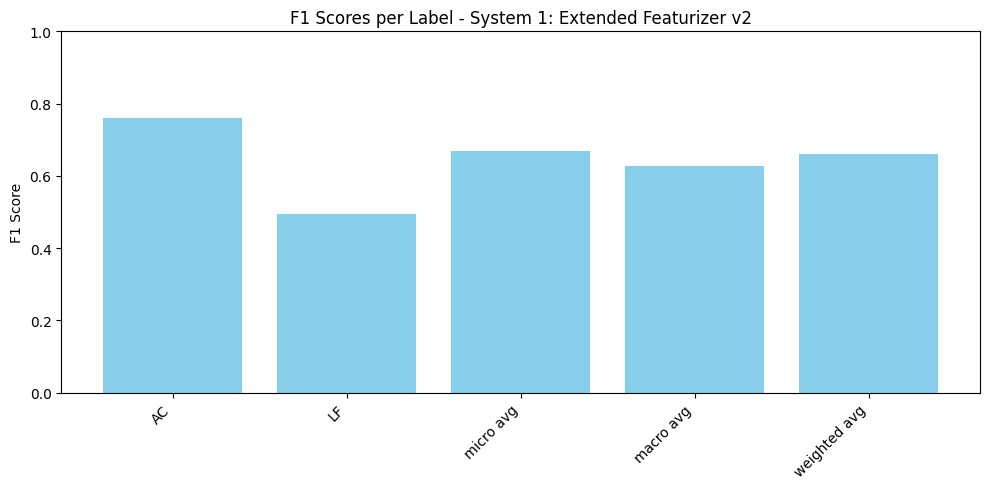

In [47]:
# Variation 1: Basic Features
def basic_featurizer_v1(sent):
    return [{'word': word.lower(), 'suffix3': word[-3:].lower()} for word in sent]

# Variation 2: Extended Features
def basic_featurizer_v2(sent):
    return [{
        'word': word.lower(),
        'prefix3': word[:3].lower(),
        'suffix3': word[-3:].lower(),
        'is_cap': word[0].isupper(),
        'is_no_cap': word[0].islower()
    } for word in sent]

# Initialize model
sys1_crf = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=0.01,
    max_iterations=200,
    linesearch='StrongBacktracking',
    all_possible_transitions=True
)

# Run for both feature variations
run_crf_pipeline(basic_featurizer_v1, dataset, sys1_crf, variation_name="System 1: Basic Featurizer v1")
run_crf_pipeline(basic_featurizer_v2, dataset, sys1_crf, variation_name="System 1: Extended Featurizer v2")

# System 2 : CRF with Advanced Features (POS tags, n-grams)

/root/nltk_data/taggers/averaged_perceptron_tagger

=== Running CRF Pipeline: System 2: Advanced Featurizer v1 ===



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


=== Validation Set Report ===
              precision    recall  f1-score   support

          AC       0.83      0.76      0.79       508
          LF       0.67      0.64      0.65       306

   micro avg       0.77      0.72      0.74       814
   macro avg       0.75      0.70      0.72       814
weighted avg       0.77      0.72      0.74       814


=== Test Set Report ===
{'AC': {'precision': np.float64(0.8464619492656876), 'recall': np.float64(0.795483061480552), 'f1-score': np.float64(0.8201811125485122), 'support': np.int64(797)}, 'LF': {'precision': np.float64(0.7096069868995634), 'recall': np.float64(0.6742738589211619), 'f1-score': np.float64(0.6914893617021277), 'support': np.int64(482)}, 'micro avg': {'precision': np.float64(0.7945318972659486), 'recall': np.float64(0.7498045347928068), 'f1-score': np.float64(0.7715205148833468), 'support': np.int64(1279)}, 'macro avg': {'precision': np.float64(0.7780344680826254), 'recall': np.float64(0.7348784602008569), 'f1-score': np

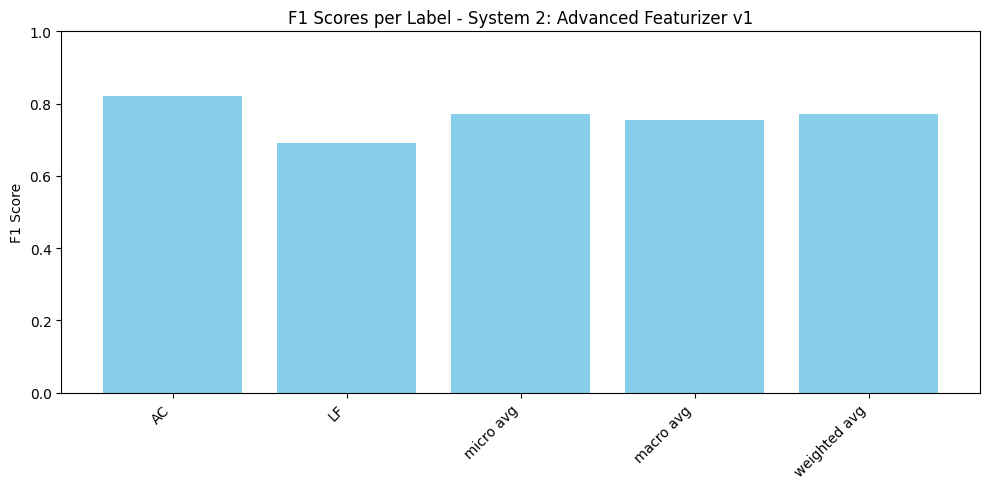

In [53]:
import nltk
from nltk.util import ngrams
from nltk.stem import PorterStemmer
from nltk import pos_tag

# Download required NLTK resources
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

print(nltk.data.find('taggers/averaged_perceptron_tagger'))

# Initialize stemmer
stemmer = PorterStemmer()

def extract_common_features(sent, i, bigrams, trigrams):
    """
    Extract common features for a given word in a sentence.

    :param sent: List of words in the sentence.
    :param i: Index of the current word.
    :param bigrams: List of bigrams for the sentence.
    :param trigrams: List of trigrams for the sentence.
    :return: Dictionary of common features.
    """
    word = sent[i]

    # Get surrounding words
    prev_word = sent[i-1].lower() if i > 0 else '<START>'
    next_word = sent[i+1].lower() if i < len(sent)-1 else '<END>'

    # Get n-grams
    curr_bigram = bigrams[i] if i < len(bigrams) else ('<END>', '<END>')
    curr_trigram = trigrams[i] if i < len(trigrams) else ('<END>', '<END>', '<END>')

    features = {
        # Word features
        'word': word.lower(),
        'stem': stemmer.stem(word),
        'length': len(word),

        # N-gram features
        'bigram': f"{curr_bigram[0].lower()}_{curr_bigram[1].lower()}",
        'trigram': f"{curr_trigram[0].lower()}_{curr_trigram[1].lower()}_{curr_trigram[2].lower()}",

        # Context features
        'prev_word': prev_word,
        'next_word': next_word,
        'prev_next': f"{prev_word}_{next_word}",

        # Orthographic features
        'is_cap': word[0].isupper(),
        'is_num': word.isdigit(),
        'has_hyphen': '-' in word,
        'prefix3': word[:3].lower(),
        'suffix3': word[-3:].lower()
    }
    return features

def advanced_featurizer_v1(sent):
    """
    Feature extractor without POS tagging.

    :param sent: List of words in the sentence.
    :return: List of feature dictionaries for each word.
    """
    bigrams = list(ngrams(sent, 2))
    trigrams = list(ngrams(sent, 3))
    features = [extract_common_features(sent, i, bigrams, trigrams) for i in range(len(sent))]
    return features

def advanced_featurizer_v2(sent):
    """
    Feature extractor with POS tagging.

    :param sent: List of words in the sentence.
    :return: List of feature dictionaries for each word.
    """
    pos_tags = pos_tag(sent)
    bigrams = list(ngrams(sent, 2))
    trigrams = list(ngrams(sent, 3))
    features = []
    for i in range(len(sent)):
        feature = extract_common_features(sent, i, bigrams, trigrams)
        # Add POS features
        current_pos = pos_tags[i][1]
        prev_pos = pos_tags[i-1][1] if i > 0 else '<START_POS>'
        next_pos = pos_tags[i+1][1] if i < len(sent)-1 else '<END_POS>'
        feature.update({
            'pos': current_pos,
            'prev_pos': prev_pos,
            'next_pos': next_pos,
            'pos_trigram': f"{prev_pos}_{current_pos}_{next_pos}",
        })
        features.append(feature)
    return features

# Initialize model
sys2_crf = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=0.01,
    max_iterations=200,
    linesearch='StrongBacktracking',
    all_possible_transitions=True
)

# Run for both feature variations
run_crf_pipeline(advanced_featurizer_v1, dataset, sys1_crf, variation_name="System 2: Advanced Featurizer v1")
# run_crf_pipeline(advanced_featurizer_v2, dataset, sys1_crf, variation_name="System 2: Advanced Featurizer v1")

# System 3: BERT + FFNN